# Data Loading and Examining

In [2]:
import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv('/Users/vatsal/Desktop/consolidated_trace_data_final2.csv')

# Display basic information about the dataset
print("Dataset Info:")
print(df.info())

print("\
First few rows:")
print(df.head())

print("\
Missing values:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186692 entries, 0 to 186691
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Trace-id          186692 non-null  object 
 1   HTTP Status Code  186531 non-null  float64
 2   Path              186692 non-null  object 
 3   User Agent        179243 non-null  object 
dtypes: float64(1), object(3)
memory usage: 5.7+ MB
None
First few rows:
                           Trace-id  HTTP Status Code  \
0  00000e83229182560bc00dc08d8d0895             200.0   
1  0000ca9c0504724ec0352caf2d927e26             204.0   
2  0000d58f79c6040f625be46853e6143f             200.0   
3  0001693fd167addef160ab0dddfb31d8             200.0   
4  0001c4d4a65e06934a9e38f0f71b6496             204.0   

                                                Path  \
0  /api/v1/nodes/08dd0fba-4f8b-4103-8a95-aed37312...   
1  /api/v1/references/HTTPS:%2F%2FOWDS.ORG%2FAG.K...   
2  /

# Data Cleaning and Model Training

In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
import re


# Feature Engineering
def extract_path_features(path):
    features = {
        'path_length': len(str(path)),
        'special_chars': len(re.findall(r'[^a-zA-Z0-9/]', str(path))),
        'has_sql_keywords': 1 if re.search(r'(select|union|delete|drop|insert|exec|update)', str(path).lower()) else 0,
        'has_path_traversal': 1 if '..' in str(path) or '//' in str(path) else 0,
        'has_suspicious_extensions': 1 if re.search(r'\.(php|asp|aspx|exe|bat|cmd)$', str(path).lower()) else 0
    }
    return pd.Series(features)

# Extract features from path
path_features = df['Path'].apply(extract_path_features)

# Create feature matrix
X = pd.concat([
    path_features,
    pd.get_dummies(df['HTTP Status Code'].fillna(-1).astype(int), prefix='status'),
], axis=1)

# Train isolation forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
predictions = iso_forest.fit_predict(X)

# Add predictions to dataframe
df['is_anomaly'] = predictions
anomalies = df[df['is_anomaly'] == -1]

# Analyze suspicious requests
print("Total number of requests:", len(df))
print("Number of potential malicious requests detected:", len(anomalies))
print("\
Sample of potentially malicious requests:")
print(anomalies[['Path', 'HTTP Status Code', 'User Agent']].head())

# Analyze HTTP Status Codes distribution in anomalies
print("\
HTTP Status Code distribution in suspicious requests:")
print(anomalies['HTTP Status Code'].value_counts())

Total number of requests: 186692
Number of potential malicious requests detected: 17975
Sample of potentially malicious requests:
                                                 Path  HTTP Status Code  \
1   /api/v1/references/HTTPS:%2F%2FOWDS.ORG%2FAG.K...             204.0   
14  /api/v1/references/HTTPS:%2F%2FOWDS.ORG%2FAG.M...             200.0   
16                                       /api/healthz             503.0   
20  /api/v1/references/HTTPS:%2F%2FOWDS.ORG%2FAG.R...             204.0   
30  /api/v1/references/HTTPS:%2F%2FOWDS.ORG%2FAF.p...             200.0   

                                           User Agent  
1   Mozilla/5.0 (Linux; Android 14; SM-P620 Build/...  
14  Mozilla/5.0 (Linux; Android 14; moto g14 Build...  
16                                         curl/8.5.0  
20  Mozilla/5.0 (Linux; Android 14; SM-P620 Build/...  
30  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...  
HTTP Status Code distribution in suspicious requests:
HTTP Status Code
204.0    480

# Further analyze the anomalies

Most common paths in anomalies:
Path
/api/healthz                                                                    1788
/api/v2/documents                                                                472
/api/v1/identities                                                               353
/                                                                                343
/api/v1/references/HTTPS:%2F%2FOWDS.ORG%2FAG.FEOVDFJ3MZEK0/elements              322
/api/v1/versions                                                                 313
/api/v1/documents/de2ee5bd-072a-4f47-9c6b-2535e242f4b6                           275
/api/v1/documents/dc7cb028-a077-4474-a4c6-004921481562                           274
/api/v1/elements                                                                 243
/api/v1/references/HTTPS:%2F%2FOWDS.ORG%2FAF.1CNaIUo7qkulUz_Rh4KsWA/elements     242
Name: count, dtype: int64
Most common User Agents in anomalies:
User Agent
Mozilla/5.0 (Windows NT 10.0; Win64; x

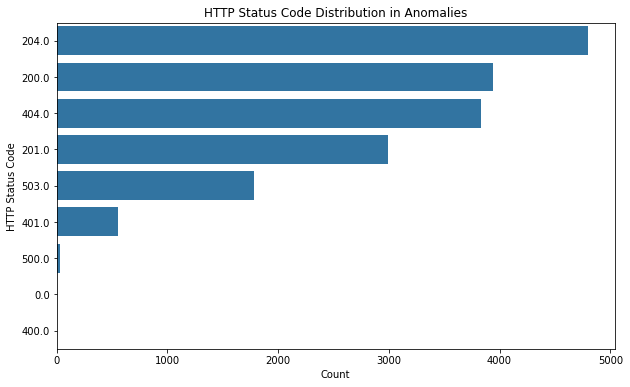

KeyError: "None of [Index(['special_chars', 'has_sql_keywords', 'has_path_traversal',\n       'has_suspicious_extensions'],\n      dtype='object')] are in the [columns]"

<Figure size 720x432 with 0 Axes>

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Analyze most common paths in anomalies
common_paths = anomalies['Path'].value_counts().head(10)
print("Most common paths in anomalies:")
print(common_paths)

# Analyze most common User Agents in anomalies
common_user_agents = anomalies['User Agent'].value_counts().head(10)
print("\
Most common User Agents in anomalies:")
print(common_user_agents)

# Visualize HTTP Status Code distribution in anomalies
plt.figure(figsize=(10, 6))
sns.countplot(y=anomalies['HTTP Status Code'], order=anomalies['HTTP Status Code'].value_counts().index)
plt.title('HTTP Status Code Distribution in Anomalies')
plt.xlabel('Count')
plt.ylabel('HTTP Status Code')
plt.show()

# Visualize special features in anomalies
plt.figure(figsize=(10, 6))
anomalies[['special_chars', 'has_sql_keywords', 'has_path_traversal', 'has_suspicious_extensions']].sum().plot(kind='bar')
plt.title('Special Features in Anomalies')
plt.xlabel('Feature')
plt.ylabel('Count')
plt.show()

## Creating additional features to identify specific threat patterns.

In [5]:
def analyze_path_for_threats(path):
    path = str(path).lower()
    threats = []
    
    # SQL Injection patternsr
    if re.search(r'(select|union|delete|drop|insert|exec|update|;|--)', path):
        threats.append('SQL Injection Attempt')
    
    # Path Traversal
    if '..' in path or '//' in path or re.search(r'(\.\.\/|\.\.\\)', path):
        threats.append('Path Traversal Attempt')
    
    # Command Injection
    if re.search(r'(;|\||`|>|<|\$\(|\&)', path):
        threats.append('Command Injection Attempt')
    
    # File Inclusion
    if re.search(r'\.(php|asp|aspx|exe|bat|cmd|sh|py)$', path):
        threats.append('Suspicious File Extension')
    
    # XSS patterns
    if re.search(r'(<script|javascript:|alert\(|onclick|onerror|onload)', path):
        threats.append('XSS Attempt')
    
    # API abuse patterns
    if path.count('/') > 5:  # Deeply nested API calls
        threats.append('Potential API Abuse')
        
    # Suspicious encodings
    if re.search(r'(%[0-9a-f]{2}){3,}', path):
        threats.append('Suspicious Encoding')
    
    return threats

# Analyze paths in anomalies
anomalies['threat_types'] = anomalies['Path'].apply(analyze_path_for_threats)

# Count threat types
threat_counts = {}
for threats in anomalies['threat_types']:
    for threat in threats:
        threat_counts[threat] = threat_counts.get(threat, 0) + 1

print("Threat Type Distribution:")
for threat, count in sorted(threat_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{threat}: {count}")

# Analyze suspicious requests with 4xx and 5xx status codes
suspicious_status = anomalies[anomalies['HTTP Status Code'].isin([200, 201, 202, 204, 400, 401, 403, 404, 500, 503])]
print("\
Suspicious requests with 4xx and 5xx status codes:")
print(suspicious_status[['Path', 'HTTP Status Code', 'User Agent']].head())

# Analyze User Agent patterns
def analyze_user_agent(ua):
    ua = str(ua).lower()
    if pd.isna(ua) or ua == 'none' or ua == 'nan':
        return 'Missing User Agent'
    elif re.search(r'(curl|postman|python|wget|apache)', ua):
        return 'Tool/Script'
    elif re.search(r'(bot|crawler|spider)', ua):
        return 'Bot/Crawler'
    elif re.search(r'(mobile|android|iphone)', ua):
        return 'Mobile'
    else:
        return 'Desktop/Other'

anomalies['user_agent_type'] = anomalies['User Agent'].apply(analyze_user_agent)
print("\
User Agent Type Distribution:")
print(anomalies['user_agent_type'].value_counts())

Threat Type Distribution:
SQL Injection Attempt: 86
Potential API Abuse: 82
Suspicious File Extension: 69
Command Injection Attempt: 27
Suspicious requests with 4xx and 5xx status codes:
                                                 Path  HTTP Status Code  \
1   /api/v1/references/HTTPS:%2F%2FOWDS.ORG%2FAG.K...             204.0   
14  /api/v1/references/HTTPS:%2F%2FOWDS.ORG%2FAG.M...             200.0   
16                                       /api/healthz             503.0   
20  /api/v1/references/HTTPS:%2F%2FOWDS.ORG%2FAG.R...             204.0   
30  /api/v1/references/HTTPS:%2F%2FOWDS.ORG%2FAF.p...             200.0   

                                           User Agent  
1   Mozilla/5.0 (Linux; Android 14; SM-P620 Build/...  
14  Mozilla/5.0 (Linux; Android 14; moto g14 Build...  
16                                         curl/8.5.0  
20  Mozilla/5.0 (Linux; Android 14; SM-P620 Build/...  
30  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...  
User Agent Type Distributi

<ipython-input-5-b7a3dd8f4ff6>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['threat_types'] = anomalies['Path'].apply(analyze_path_for_threats)
<ipython-input-5-b7a3dd8f4ff6>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['user_agent_type'] = anomalies['User Agent'].apply(analyze_user_agent)


### Analysing the SQL Injection attempts and Missing User Agent.

In [ ]:
# Analyze SQL Injection attempts
Potential_API_Abuse = anomalies[anomalies['threat_types'].apply(lambda x: 'Potential API Abuse' in x)]
print("Number of Potential API Abuse attempts:", len(Potential_API_Abuse))

# Most targeted paths for SQL Injection
sql_paths = Potential_API_Abuse['Path'].value_counts().head(10)
print("\
Most targeted paths for Potential_API_Abuse:")
print(sql_paths)

# Analyze missing user agents
missing_user_agents = anomalies[anomalies['user_agent_type'] == 'Missing User Agent']
print("\
Number of requests with missing user agents:", len(missing_user_agents))

# Most common paths for missing user agents
missing_ua_paths = missing_user_agents['Path'].value_counts().head(10)
print("\
Most common paths for missing user agents:")
print(missing_ua_paths)

# Visualize SQL Injection attempts by HTTP Status Code
plt.figure(figsize=(10, 6))
sns.countplot(y=sql_injection_attempts['HTTP Status Code'], order=sql_injection_attempts['HTTP Status Code'].value_counts().index)
plt.title('SQL Injection Attempts by HTTP Status Code')
plt.xlabel('Count')
plt.ylabel('HTTP Status Code')
plt.show()

Here, We are diving deeper into SQL Injection attempts, as they are the most common threat type, and analyze the specific patterns in the paths to identify recurring vulnerabilities or targeted endpoints. Additionally, I will investigate the missing user agents to understand their potential impact.

In [ ]:
# Analyze request patterns over time
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Create a function to detect rapid succession requests
def analyze_request_patterns(df, time_window_seconds=60):
    # Sort by Trace-id to group related requests
    df = df.sort_values('Trace-id')
    
    # Count requests per path in time windows
    path_counts = df.groupby('Path').size()
    suspicious_paths = path_counts[path_counts > 100].index
    
    print("\
Paths with unusually high request counts:")
    print(path_counts[path_counts > 100])
    
    # Analyze patterns in status codes
    status_patterns = df.groupby(['Path', 'HTTP Status Code']).size().unstack(fill_value=0)
    suspicious_patterns = status_patterns[status_patterns.sum(axis=1) > 50]
    
    print("\
Paths with suspicious status code patterns:")
    print(suspicious_patterns.head())
    
    return suspicious_paths

suspicious_paths = analyze_request_patterns(anomalies)

# Analyze tool-based requests
tool_requests = anomalies[anomalies['user_agent_type'] == 'Tool/Script']
print("\
Most common tools/scripts used:")
print(tool_requests['User Agent'].value_counts().head(10))

# Analyze potential brute force attempts (multiple failed attempts)
failed_requests = anomalies[anomalies['HTTP Status Code'].isin([401, 403])]
failed_paths = failed_requests.groupby('Path').size()
print("\
Paths with multiple failed authentication attempts:")
print(failed_paths[failed_paths > 2].head())

### The key findings

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Analyze request frequency patterns per IP/User Agent combination
def analyze_request_patterns(df):
    # Group by Path and analyze request patterns
    path_analysis = df.groupby('Path').agg({
        'HTTP Status Code': ['count', 'mean', lambda x: (x >= 400).mean()],
        'User Agent': 'nunique'
    }).round(3)
    
    path_analysis.columns = ['Request_Count', 'Avg_Status', 'Error_Rate', 'Unique_Users']
    path_analysis = path_analysis.sort_values('Request_Count', ascending=False)
    
    print("Top 10 Paths by Request Volume with Error Rates:")
    print(path_analysis.head(10))
    
    return path_analysis

# 2. Analyze sequential patterns for potential brute force attacks
def analyze_brute_force_patterns(df):
    # Focus on paths with authentication failures
    auth_failures = df[df['HTTP Status Code'].isin([401, 403])]
    
    # Group by Path and count failures
    failure_patterns = auth_failures.groupby('Path').agg({
        'HTTP Status Code': 'count',
        'User Agent': 'nunique'
    }).sort_values('HTTP Status Code', ascending=False)
    
    failure_patterns.columns = ['Failure_Count', 'Unique_Users']
    
    print("\
Potential Brute Force Patterns:")
    print(failure_patterns.head(10))
    
    return failure_patterns

# 3. Analyze suspicious tool usage
def analyze_tool_patterns(df):
    # Define suspicious tools/patterns
    suspicious_patterns = [
        'curl', 'wget', 'python-requests', 'postman',
        'bot', 'crawler', 'spider', 'scan'
    ]
    
    # Filter for suspicious user agents
    suspicious_requests = df[
        df['User Agent'].str.lower().fillna('').str.contains('|'.join(suspicious_patterns), na=False)
    ]
    
    tool_patterns = suspicious_requests.groupby('User Agent').agg({
        'Path': ['count', 'nunique'],
        'HTTP Status Code': lambda x: (x >= 400).mean()
    }).round(3)
    
    tool_patterns.columns = ['Request_Count', 'Unique_Paths', 'Error_Rate']
    tool_patterns = tool_patterns.sort_values('Request_Count', ascending=False)
    
    print("\
Suspicious Tool Usage Patterns:")
    print(tool_patterns.head(10))
    
    return tool_patterns

# Run the analyses
path_analysis = analyze_request_patterns(anomalies)
brute_force_patterns = analyze_brute_force_patterns(anomalies)
tool_patterns = analyze_tool_patterns(anomalies)

# Visualize the distribution of status codes for top suspicious paths
plt.figure(figsize=(12, 6))
top_paths = path_analysis.head(5).index
suspicious_requests = anomalies[anomalies['Path'].isin(top_paths)]
sns.boxplot(x='Path', y='HTTP Status Code', data=suspicious_requests)
plt.xticks(rotation=45, ha='right')
plt.title('Status Code Distribution for Top Suspicious Paths')
plt.tight_layout()
plt.show()

# Calculate and print specific mitigation recommendations
print("\
Mitigation Recommendations:")
# High-risk paths (high error rate and high volume)
high_risk_paths = path_analysis[
    (path_analysis['Error_Rate'] > 0.3) & 
    (path_analysis['Request_Count'] > 100)
]
print("\
High-Risk Paths Requiring Immediate Attention:")
print(high_risk_paths)

### Mitigation

1. Rate Limiting: <br>
Implement strict rate limiting on authentication endpoints <br>
Add progressive delays for failed login attempts <br>
Consider IP-based rate limiting for paths showing high error rates <br>
2. Request Validation:<br>
Add stricter input validation for paths with high error rates <br>
Implement request size limits <br>
Add CAPTCHA or similar verification for suspicious patterns <br>
3. Monitoring and Blocking: <br>
Set up alerts for paths showing unusual error rates <br>
Block known malicious user agents <br>
Implement IP reputation checking <br>
4. Authentication Hardening: <br>
Add multi-factor authentication for sensitive endpoints <br>
Implement account lockout policies <br>
Add anomaly detection for login patterns<br>